In [1]:
import gzip
from collections import defaultdict
import random
import math
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse(f):
    for l in gzip.open(f):
        yield eval(l)

In [3]:
# read data from file
file = "../goodreads_reviews_comics_graphic.json.gz"
data = list(parse(file))

In [4]:
# Data structures 
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
ratings = []

In [5]:
for d in data:
    user,item = d['user_id'],d['book_id']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratings.append(d['rating'])

### Data sampling ###

Our dataset consists of 542338 book reviews. Due to memory constraints we need to reduce the size of our dataset. Let's take a closer look at our data to sample the most reasonable set of users and books.

In [6]:
t = PrettyTable(['# of reviews', '# of users','# of books','min rating','max rating','average rating'])
t.add_row([len(data),len(itemsPerUser),len(usersPerItem),min(ratings),max(ratings),sum(ratings)/len(ratings)])
print(t)

+--------------+------------+------------+------------+------------+-------------------+
| # of reviews | # of users | # of books | min rating | max rating |   average rating  |
+--------------+------------+------------+------------+------------+-------------------+
|    542338    |   59347    |   89311    |     0      |     5      | 3.778138356523054 |
+--------------+------------+------------+------------+------------+-------------------+


In [7]:
reviewsPerUserCount = [(len(reviewsPerUser[u]),u) for u in reviewsPerUser]
reviewsPerUserCount.sort()
reviewsPerUserCount.reverse()
print('Reviewers with highest number of reviews:\n', reviewsPerUserCount[:5])

Reviewers with highest number of reviews:
 [(2850, '37b3e60b4e4152c580fd798d405150ff'), (2760, 'b00c1d9dc54763b9b365b54dc68485f8'), (1877, '459a6c4decf925aedd08e45045c0d8c6'), (1631, 'c05512c006dd9ccb49b147ce619621d5'), (1482, '1dcc10935c0022c1bd9c7a3067b883c8')]


Text(0.5, 0, 'Number of reviews')

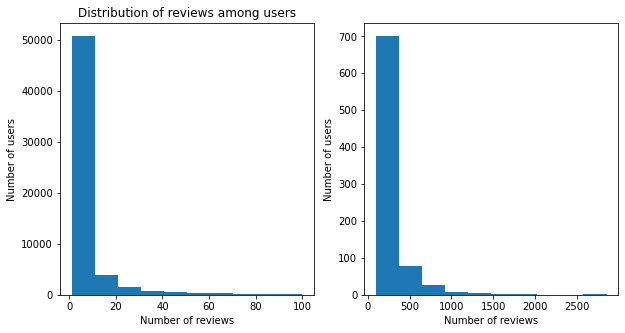

In [8]:
uCounter = defaultdict(int)
for x in reviewsPerUserCount: uCounter[x[0]]+=1
smDict = dict((k,v) for k,v in uCounter.items() if k<=100)
lgDict = dict((k,v) for k,v in uCounter.items() if k>=100)

val, weight = zip(*[(k, v) for k,v in smDict.items()])
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.hist(val, weights=weight)
plt.ylabel("Number of users")
plt.xlabel("Number of reviews")
plt.title("Distribution of reviews among users")

val, weight = zip(*[(k, v) for k,v in lgDict.items()])
plt.subplot(1,2,2)
plt.hist(val, weights=weight)
plt.ylabel("Number of users")
plt.xlabel("Number of reviews")

In [9]:
reviewsPerItemCount = [(len(reviewsPerItem[i]),i) for i in reviewsPerItem]
reviewsPerItemCount.sort()
reviewsPerItemCount.reverse()
print('Books with highest number of reviews', reviewsPerItemCount[:5])

Books with highest number of reviews [(2953, '15704307'), (2151, '17571564'), (1757, '472331'), (1742, '19351043'), (1639, '17131869')]


Text(0.5, 0, 'Number of reviews')

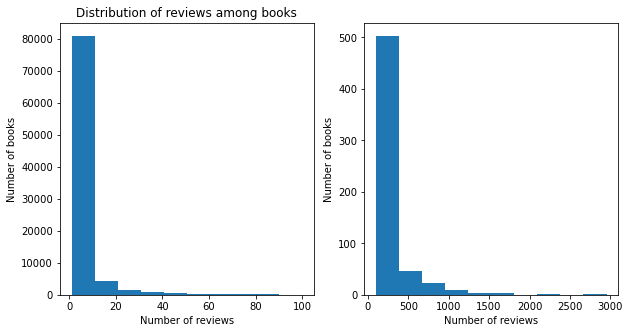

In [10]:
bCounter = defaultdict(int)
for x in reviewsPerItemCount: bCounter[x[0]]+=1
smDict = dict((k,v) for k,v in bCounter.items() if k<=100)
lgDict = dict((k,v) for k,v in bCounter.items() if k>=100)

val, weight = zip(*[(k, v) for k,v in smDict.items()])
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.hist(val, weights=weight)
plt.ylabel("Number of books")
plt.xlabel("Number of reviews")
plt.title("Distribution of reviews among books")

val, weight = zip(*[(k, v) for k,v in lgDict.items()])
plt.subplot(1,2,2)
plt.hist(val, weights=weight)
plt.ylabel("Number of books")
plt.xlabel("Number of reviews")

Both distributions of reviews among different users and books are highly right-skewed. We reduce our dataset by keeping only users and books with at least 200 reviews.

In [69]:
topReviewers = [r for c,r in reviewsPerUserCount if c>200]
topBooks = [b for c,b in reviewsPerItemCount if c>200]

In [70]:
sample = [d for d in data if d['user_id'] in topReviewers and d['book_id'] in topBooks]

In [71]:
print("This leaves us with "+str(len(sample))+" reviews among "+str(len(topReviewers))+" users and "+str(len(topBooks))+" books.")

This leaves us with 8617 reviews among 294 users and 229 books.


### Splitting data into training and test sets ###

In [72]:
random.shuffle(sample)
trainData = sample[:len(sample)//2]
testData = sample[len(sample)//2:]
testLabels = [d['rating'] for d in testData]

### Data analysis ###
Now our dataset, which will be used for making rating predictions for new data points (trainData), consists of 8617 book reviews. Each contains information such as the user_id, book_id, rating, review_text, date when it was added and updated, etc. In our predicting models based on collaborative filtering we only need information on user-book relationships and the ratings given by a user to a book, which we can collect using following data structures.

In [73]:
trainData[0]

{'user_id': 'fd83f1c59d1b7b9b9830d197a755eff4',
 'book_id': '29801',
 'review_id': '9fcf08e05a7cfe9660b4e7b3023ed6ad',
 'rating': 4,
 'review_text': "The comic book in which hero plays video games and his life is a video game as well. I loved the movie after which I learned about the graphic novels. In this volume Scott fight's Ramona's 2nd Evil Boyfriend and breaks up with his girl friend Knives Chou. We also get to know about the 3rd Evil boyfriend. So far so good 3rd part sometimes later.",
 'date_added': 'Wed Oct 08 21:22:45 -0700 2014',
 'date_updated': 'Thu Oct 09 03:31:42 -0700 2014',
 'read_at': 'Thu Oct 09 03:31:42 -0700 2014',
 'started_at': 'Wed Oct 08 00:00:00 -0700 2014',
 'n_votes': 0,
 'n_comments': 0}

In [197]:
# Data structures 
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
ratings = []
for d in trainData:
    user,item = d['user_id'],d['book_id']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratings.append(d['rating'])

In [198]:
t = PrettyTable(['# of reviews', '# of users','# of books','min rating','max rating','average rating'])
t.add_row([len(trainData),len(itemsPerUser),len(usersPerItem),min(ratings),max(ratings),sum(ratings)/len(ratings)])
print(t)

+--------------+------------+------------+------------+------------+--------------------+
| # of reviews | # of users | # of books | min rating | max rating |   average rating   |
+--------------+------------+------------+------------+------------+--------------------+
|     4308     |    283     |    229     |     0      |     5      | 3.8913649025069637 |
+--------------+------------+------------+------------+------------+--------------------+


### Model evaluation ###

### Baseline ###
Our baseline model always predicts the average rating.

In [199]:
def MSE(predictions,labels):
    difference = [(p-l)**2 for p,l in zip(predictions,labels)]
    return sum(difference)/len(difference)

In [200]:
ratingMean = sum(ratings)/len(ratings)
print("mean: ",ratingMean)

# Baseline prediction
alwaysPredictMean = [ratingMean for d in testData]

# Baseline accuracy
baselineMSE = MSE(alwaysPredictMean, testLabels)
print("MSE of the baseline: ", baselineMSE)

mean:  3.8913649025069637
MSE of the baseline:  1.2455734850286064


### Collaborative filtering ###

Different similarity functions

In [78]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer/denom

In [79]:
def Pearson(i1,i2):
    if i1 not in usersPerItem: return sum(ratings)/len(ratings)
    u1 = usersPerItem[i1]
    u2 = usersPerItem[i2]
    common = u1.intersection(u2)
    num = []
    denom1 = []
    denom2 = []
    ratingsI1 = [d['rating'] for d in reviewsPerItem[i1]]
    ratingsI2 = [d['rating'] for d in reviewsPerItem[i2]]
    averageI1 = sum(ratingsI1)/len(ratingsI1)
    averageI2 = sum(ratingsI2)/len(ratingsI2)
    if common:
        for u in common:
            # take an average of ratings in case user rated a book multiple times
            ratingsU1 = []
            ratingsU2 = []
            for d in reviewsPerItem[i1]:
                if d['user_id']==u: ratingsU1.append(d['rating'])
            for d in reviewsPerItem[i2]:        
                if d['user_id']==u: ratingsU2.append(d['rating'])
            ratingU1 = sum(ratingsU1)/len(ratingsU1)
            ratingU2 = sum(ratingsU2)/len(ratingsU2)
            num.append((ratingU1-averageI1)*(ratingU2-averageI2))
            denom1.append((ratingU1-averageI1)**2)
            denom2.append((ratingU2-averageI2)**2)
        if math.sqrt(sum(denom1)*sum(denom2)) != 0:
            # normalize to 0-1 value
            return ((sum(num)/(math.sqrt(sum(denom1)*sum(denom2))))+1)/2
        else: return 0
    else: return 0

In [85]:
def Cosine(i1,i2):
    if i1 not in usersPerItem: return sum(ratings)/len(ratings)
    u1 = usersPerItem[i1]
    u2 = usersPerItem[i2]
    common = u1.intersection(u2)
    num = []
    denom1 = []
    denom2 = [] 
    if common:
        for u in common:
            ratingsI1 = []
            ratingsI2 = []
            for d in reviewsPerItem[i1]:
                if d['user_id']==u: ratingsI1.append(d['rating'])
            for d in reviewsPerItem[i2]:        
                if d['user_id']==u: ratingsI2.append(d['rating'])
            ratingI1 = sum(ratingsI1)/len(ratingsI1)
            ratingI2 = sum(ratingsI2)/len(ratingsI2)
            num.append(ratingI1*ratingI2)
            denom1.append(ratingI1**2)
            denom2.append(ratingI2**2)
        if math.sqrt(sum(denom1)*sum(denom2)) != 0:
            return (sum(num)/(math.sqrt(sum(denom1)*sum(denom2))))
        else: return 0
    else: return 0

### Item-based collaborative filtering ###

In [119]:
def predictRating(user,item,simFunction):
    ratingsU = []
    similarities = []
    reviewsU = reviewsPerUser[user]
    for r in reviewsU:
        item2 = r['book_id']
        if item2 != item:
            ratingsU.append(r['rating'])
            if simFunction == 'Jaccard': similarities.append(Jaccard(usersPerItem[item],usersPerItem[item2]))
            elif simFunction == 'Pearson': similarities.append(Pearson(item,item2))
            elif simFunction == 'Cosine': similarities.append(Cosine(item,item2))
    if (sum(similarities)>0):
        weightedRatings = [(x*y) for x,y in zip(ratingsU,similarities)]
        return sum(weightedRatings)/sum(similarities)
    else:
        return ratingMean

In [201]:
# Collaborative filtering using Jaccard similarity
cfJaccard = [predictRating(d['user_id'], d['book_id'], 'Jaccard') for d in testData]

In [83]:
# Collaborative filtering using Pearson similarity
cfPearson = [predictRating(d['user_id'], d['book_id'], 'Pearson') for d in testData]

In [86]:
# Collaborative filtering using Cosine similarity
cfCosine = [predictRating(d['user_id'], d['book_id'], 'Cosine') for d in testData]

In [88]:
e = [(a,b,c,d) for a,b,c,d in zip(testLabels,cfJaccard,cfPearson,cfCosine)]
t = PrettyTable(['Actual rating', 'Jaccard','Pearson','Cosine'])
for r in e[:5]:
    t.add_row([r[0],r[1],r[2],r[3]])
print(t)

+---------------+--------------------+--------------------+--------------------+
| Actual rating |      Jaccard       |      Pearson       |       Cosine       |
+---------------+--------------------+--------------------+--------------------+
|       4       | 3.844536418504196  | 3.6652139582328687 |  3.89175660172943  |
|       1       | 2.647930119151743  | 2.2525487309564767 | 2.5065353436829536 |
|       4       | 3.1750423874980687 | 3.1290289949804864 | 3.222280890545422  |
|       3       | 3.6038393660823376 | 3.527166750718305  | 3.5470433609684293 |
|       5       | 4.4557855018053445 | 4.379787612915057  | 3.9302087397299452 |
+---------------+--------------------+--------------------+--------------------+


In [203]:
# Collaborative filtering using Jaccard similarity accuracy
jaccardMSE = MSE(cfJaccard, testLabels)
# Collaborative filtering using Pearson similarity accuracy
pearsonMSE = MSE(cfPearson, testLabels)
# Collaborative filtering using Cosine similarity accuracy
cosineMSE = MSE(cfCosine, testLabels)

In [90]:
t = PrettyTable(['Baseline', 'Jaccard','Pearson','Cosine'])
t.add_row([baselineMSE,jaccardMSE,pearsonMSE,cosineMSE])
print(t)

+--------------------+--------------------+--------------------+--------------------+
|      Baseline      |      Jaccard       |      Pearson       |       Cosine       |
+--------------------+--------------------+--------------------+--------------------+
| 1.2559819832546966 | 0.8771188414643859 | 0.6910688302772856 | 0.9842940446174275 |
+--------------------+--------------------+--------------------+--------------------+


### User-based collaborative filtering ###

In [129]:
def Pearson2(u1,u2):
    if u1 not in itemsPerUser: return sum(ratings)/len(ratings)
    i1 = itemsPerUser[u1]
    i2 = itemsPerUser[u2]
    common = i1.intersection(i2)
    num = []
    denom1 = []
    denom2 = []
    ratingsI1 = [d['rating'] for d in reviewsPerUser[u1]]
    ratingsI2 = [d['rating'] for d in reviewsPerUser[u2]]
    averageI1 = sum(ratingsI1)/len(ratingsI1)
    averageI2 = sum(ratingsI2)/len(ratingsI2)
    if common:
        for i in common:
            # take an average of ratings in case user rated a book multiple times
            ratingsU1 = []
            ratingsU2 = []
            for d in reviewsPerItem[i]:
                if d['user_id']==u1: ratingsU1.append(d['rating'])
                if d['user_id']==u2: ratingsU2.append(d['rating'])
            ratingU1 = sum(ratingsU1)/len(ratingsU1)
            ratingU2 = sum(ratingsU2)/len(ratingsU2)
            num.append((ratingU1-averageI1)*(ratingU2-averageI2))
            denom1.append((ratingU1-averageI1)**2)
            denom2.append((ratingU2-averageI2)**2)
        if math.sqrt(sum(denom1)*sum(denom2)) != 0:
            # normalize to 0-1 value
            return ((sum(num)/(math.sqrt(sum(denom1)*sum(denom2))))+1)/2
        else: return 0
    else: return 0

In [133]:
def Cosine2(u1,u2):
    if u1 not in itemsPerUser: return sum(ratings)/len(ratings)
    i1 = itemsPerUser[u1]
    i2 = itemsPerUser[u2]
    common = i1.intersection(i2)
    num = []
    denom1 = []
    denom2 = [] 
    if common:
        for i in common:
            ratingsI1 = []
            ratingsI2 = []
            for d in reviewsPerItem[i]:
                if d['user_id']==u1: ratingsI1.append(d['rating']) 
                if d['user_id']==u2: ratingsI2.append(d['rating'])
            ratingI1 = sum(ratingsI1)/len(ratingsI1)
            ratingI2 = sum(ratingsI2)/len(ratingsI2)
            num.append(ratingI1*ratingI2)
            denom1.append(ratingI1**2)
            denom2.append(ratingI2**2)
        if math.sqrt(sum(denom1)*sum(denom2)) != 0:
            return (sum(num)/(math.sqrt(sum(denom1)*sum(denom2))))
        else: return 0
    else: return 0

In [130]:
def predictRating2(user,item,simFunction):
    ratingsI = [] 
    similarities = []
    reviewsI = reviewsPerItem[item]
    for r in reviewsI:
        user2 = r['user_id']
        if user2 != user:
            ratingsI.append(r['rating'])
            if simFunction == 'Jaccard': similarities.append(Jaccard(itemsPerUser[user],itemsPerUser[user2]))
            elif simFunction == 'Pearson': similarities.append(Pearson2(user,user2))
            elif simFunction == 'Cosine': similarities.append(Cosine2(user,user2))
    if (sum(similarities)>0):
        weightedRatings = [(x*y) for x,y in zip(ratingsI,similarities)]
        return sum(weightedRatings)/sum(similarities)
    else:
        return ratingMean

In [99]:
# Collaborative filtering using Jaccard similarity
cfJaccard2 = [predictRating2(d['user_id'], d['book_id'], 'Jaccard') for d in testData]

In [131]:
# Collaborative filtering using Pearson similarity
cfPearson2 = [predictRating2(d['user_id'], d['book_id'], 'Pearson') for d in testData]

In [134]:
# Collaborative filtering using Cosine similarity
cfCosine2 = [predictRating2(d['user_id'], d['book_id'], 'Cosine') for d in testData]

In [151]:
e = [(a,b,c,d) for a,b,c,d in zip(testLabels,cfJaccard2,cfPearson2,cfCosine2)]
t = PrettyTable(['Actual rating','user-based Jaccard','user-based Pearson','user-based Cosine'])
for r in e[:5]:
    t.add_row([r[0],r[1],r[2],r[3]])
print(t)

+---------------+--------------------+--------------------+--------------------+
| Actual rating | user-based Jaccard | user-based Pearson | user-based Cosine  |
+---------------+--------------------+--------------------+--------------------+
|       4       | 4.201180949684633  | 4.190832671310498  | 4.2487480983514425 |
|       1       | 3.885740312441797  | 3.606022018207336  | 3.9330720944288005 |
|       4       | 4.239143283209285  | 4.578265233136626  | 4.307376996037624  |
|       3       | 3.898801547299815  | 3.808849244157558  | 3.9692511788480664 |
|       5       | 4.102912919070726  | 4.357963743957524  | 4.146391736449272  |
+---------------+--------------------+--------------------+--------------------+


In [146]:
# Collaborative filtering using Jaccard similarity accuracy
jaccardMSE2 = MSE(cfJaccard2, testLabels)
# Collaborative filtering using Pearson similarity accuracy
pearsonMSE2 = MSE(cfPearson2, testLabels)
# Collaborative filtering using Cosine similarity accuracy
cosineMSE2 = MSE(cfCosine2, testLabels)

In [152]:
t = PrettyTable(['Baseline','user-based Jaccard','user-based Pearson','user-based Cosine'])
t.add_row([baselineMSE,jaccardMSE2,pearsonMSE2,cosineMSE2])
print(t)

+--------------------+--------------------+--------------------+--------------------+
|      Baseline      | user-based Jaccard | user-based Pearson | user-based Cosine  |
+--------------------+--------------------+--------------------+--------------------+
| 1.2559819832546966 | 1.1649299302625846 | 0.8534765567210629 | 1.1544696582905856 |
+--------------------+--------------------+--------------------+--------------------+


Clearly, models based on item-to-item collaborative filtering outperformed those based on user-to-user one regardless of the similarity function. However, while all models performed better than the baseline, models calculating similarities using Pearson's correlation coefficient clearly ouperformed the other ones.

In [163]:
def predictRating3(user,item,simFunction):
    ratingsU = []
    similarities = []
    reviewsU = reviewsPerUser[user]
    ratingsI = [d['rating'] for d in reviewsPerItem[item]]
    averageI = sum(ratingsI)/len(ratingsI)
    for r in reviewsU:
        item2 = r['book_id']
        if item2 != item:
            ratingsI2 = [d['rating'] for d in reviewsPerItem[item2]]
            averageI2 = sum(ratingsI2)/len(ratingsI2)
            ratingsU.append(r['rating']-averageI2)
            if simFunction == 'Jaccard': similarities.append(Jaccard(usersPerItem[item],usersPerItem[item2]))
            elif simFunction == 'Pearson': similarities.append(Pearson(item,item2))
            elif simFunction == 'Cosine': similarities.append(Cosine(item,item2))
    if (sum(similarities)>0):
        weightedRatings = [(x*y) for x,y in zip(ratingsU,similarities)]
        return averageI+(sum(weightedRatings)/sum(similarities))
    else:
        return ratingMean

### Further improvement ###
We can further improve our rating predictions by slightly modifying our weighted average rating calculations. Instead of multiplying each item's/user's similarity value by their rating, we can first subtract their mean rating to weight deviations from the mean. This accounts for a lot of items receiving/users giving out very high/low ratings.

In [178]:
cfJaccard3 = [predictRating3(d['user_id'], d['book_id'], 'Jaccard') for d in testData]
jaccardMSE3 = MSE(cfJaccard3, testLabels)

In [206]:
t = PrettyTable(['Modified item-based with Jaccard similarity'])
t.add_row([jaccardMSE3])
print(t)

+---------------------------------------------+
| Modified item-based with Jaccard similarity |
+---------------------------------------------+
|              0.787214009015291              |
+---------------------------------------------+


In [170]:
# Collaborative filtering using Pearson similarity
cfPearson3 = [predictRating3(d['user_id'], d['book_id'], 'Pearson') for d in testData]
# Collaborative filtering using Pearson similarity accuracy
pearsonMSE3 = MSE(cfPearson3, testLabels)
t = PrettyTable(['Pearson with modified weighted average rating'])
t.add_row([pearsonMSE3])
print(t)

In [181]:
# average rating of every user
avgPerUser = defaultdict()
for u in reviewsPerUser:
    ratings = [d['rating'] for d in reviewsPerUser[u]]
    avgPerUser[u] = sum(ratings)/len(ratings)

Text(0.5, 1.0, "Distribution of users' average ratings")

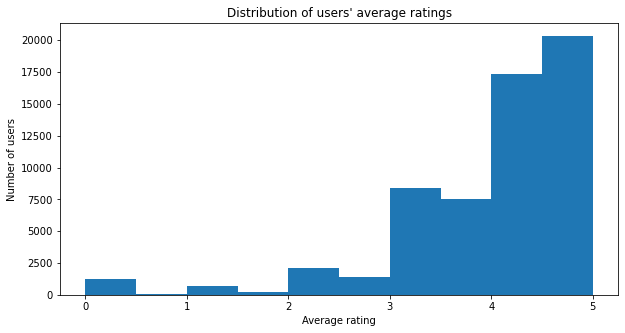

In [187]:
avgUCounter = defaultdict(int)
for x in list(avgPerUser.values()): avgUCounter[x]+=1

val, weight = zip(*[(k, v) for k,v in avgUCounter.items()])
plt.figure(figsize=[10,5])
plt.hist(val, weights=weight)
plt.ylabel("Number of users")
plt.xlabel("Average rating")
plt.title("Distribution of users' average ratings")

In [190]:
# average rating of every item
avgPerItem = defaultdict()
for i in reviewsPerItem:
    ratings = [d['rating'] for d in reviewsPerItem[i]]
    avgPerItem[i] = sum(ratings)/len(ratings)

Text(0.5, 1.0, "Distribution of items' average ratings")

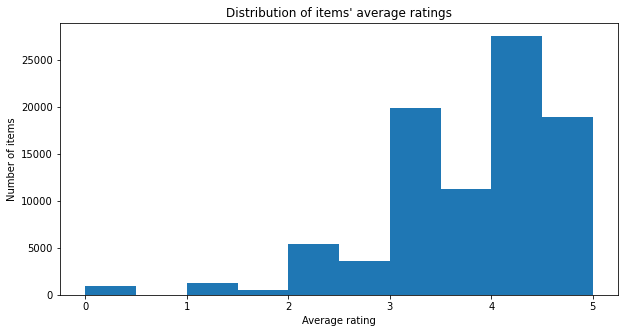

In [195]:
avgICounter = defaultdict(int)
for x in list(avgPerItem.values()): avgICounter[x]+=1

val, weight = zip(*[(k, v) for k,v in avgICounter.items()])
plt.figure(figsize=[10,5])
plt.hist(val, weights=weight)
plt.ylabel("Number of items")
plt.xlabel("Average rating")
plt.title("Distribution of items' average ratings")

Due to memory constraints, we run the improved model using only the Jaccard similarity function. We can see an improvement in its performance in comparison to its corresponding regular weighted average rating model. We can easily explain it by looking at the users' and items' average ratings distirbutions. Our dataset consisted of a lot of users giving out and a lot items receiving high/above average ratings.